In [1]:
###### Config #####
import sys, os, platform
if os.path.isdir("ds-assets"):
  !cd ds-assets && git pull
else:
  !git clone https://github.com/lutzhamel/ds-assets.git
colab = True if 'google.colab' in os.sys.modules else False
system = platform.system() # "Windows", "Linux", "Darwin"
home = "ds-assets/assets/"
sys.path.append(home)

Already up to date.


In [2]:
import pandas as pd
import dsutils
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

Load our data and convert it to a Pandas time series dataframe.

In [3]:
# air passenger data
air = pd.read_csv(home+'AirPassengers.csv')
air.columns = ['date','passengers'] # rename columns for convenience
air.index = pd.DatetimeIndex(air['date']) # create a time index
air.drop(columns=['date'], inplace=True)
air.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Text(0, 0.5, 'Number of Passengers')

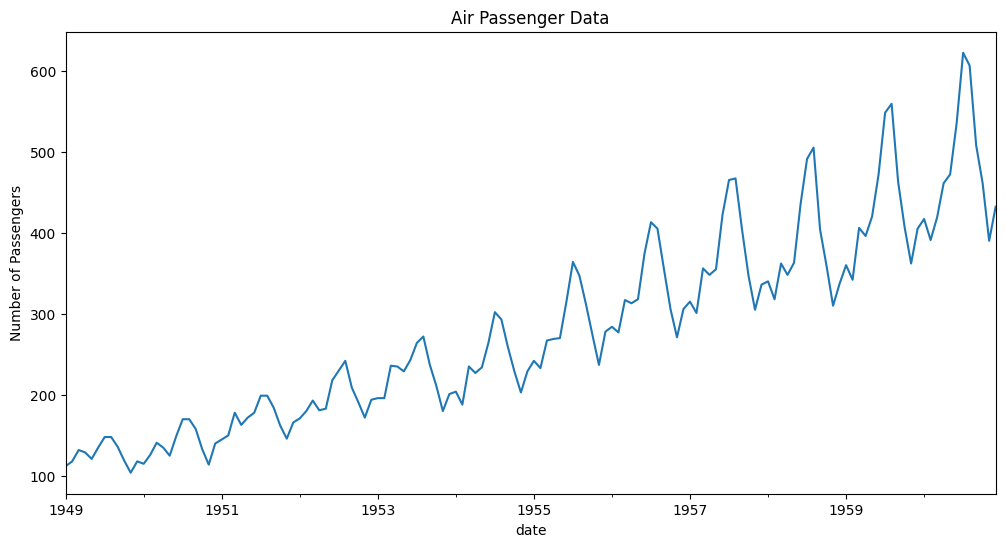

In [4]:
air.plot(figsize=(12,6), title='Air Passenger Data', legend=False)\
      .set_ylabel('Number of Passengers')

# Modeling

[source](https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/),
[source](https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python)

This is about building models of the time series in order to predict values that are not part of the training set.

## Trend Modeling

We start with trend forecasting.  We first extract the trend information from the time series by applying the rolling window methodology.

In [5]:
air_trend = air[['passengers']] \
  .rolling(12, min_periods=1) \
  .mean() \
  .set_axis(['trend'], axis=1)

Text(0, 0.5, 'Number of Passengers')

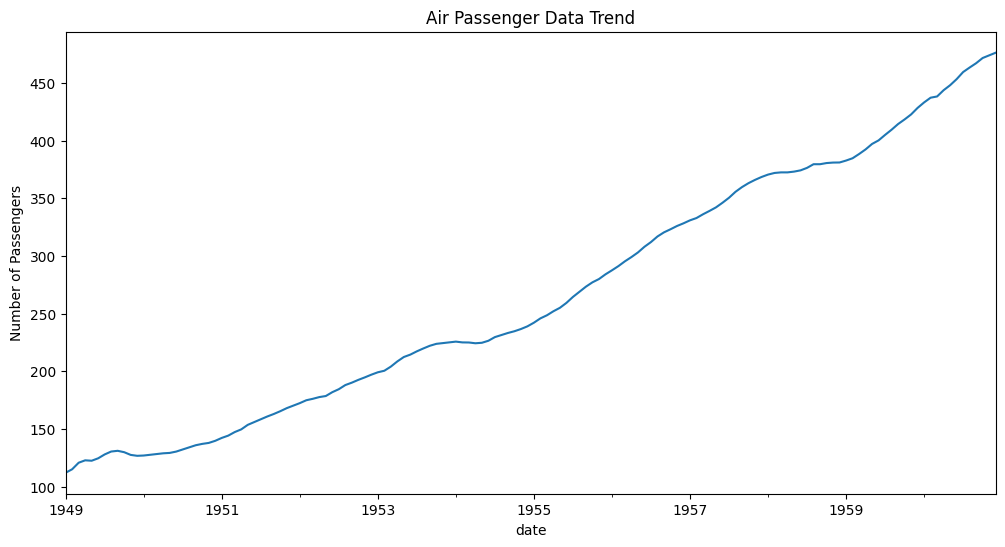

In [6]:
air_trend.plot(figsize=(12,6), title='Air Passenger Data Trend', legend=False)\
      .set_ylabel('Number of Passengers') 

### Linear Regression

We can't do linear regression with Pandas' DatetimeIndex objects as the independent variable.  Therefore, we create a new variable called **days** which simply **counts the number of days** from the start of the model data.  That new variable will become our independent variable as a proxy for the DatetimeIndex obects.  This is often called **feature engineering**.

In [7]:
model_data = air_trend.copy()
model_data['days'] = list((model_data.index - model_data.index[0]).days)
model_data

,trend,days
date,,
1949-01-01,112.000000,0
1949-02-01,115.000000,31
1949-03-01,120.666667,59
1949-04-01,122.750000,90
1949-05-01,122.400000,120
...,...,...
1960-08-01,463.333333,4230
1960-09-01,467.083333,4261
1960-10-01,471.583333,4291


In [8]:
X = model_data[['days']]
y = model_data['trend']


# Fit a linear regression model
model = LinearRegression().fit(X, y)

Text(0, 0.5, 'Number of Passengers')

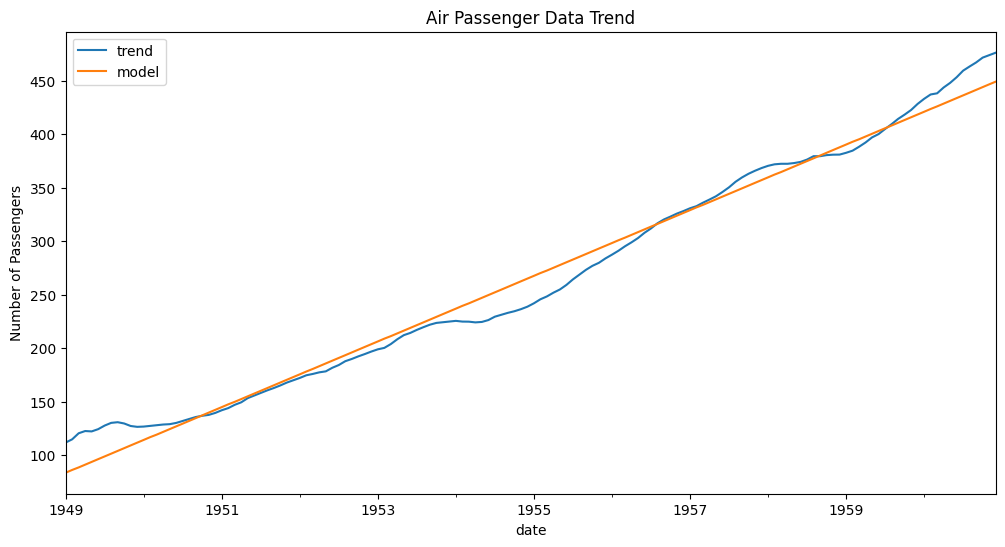

In [9]:
# visualize the fit
pd.DataFrame({'trend':model_data['trend'],
              'model':model.predict(X)})\
         .plot(figsize=(12,6), title='Air Passenger Data Trend', legend=True)\
         .set_ylabel('Number of Passengers') 


In [10]:
# compute the R^2 score
dsutils.rs_score(model, X, y, as_string=True)

'R^2 Score: 0.98 (0.98, 0.99)'

You might ask, why did we not do a linear regression on the original time series?  Surely, the linear regression would have fitted the overarching trend like so,

In [11]:
model_data2 = air.copy()
model_data2['days'] = list((model_data2.index - model_data2.index[0]).days)
model_data2

,passengers,days
date,,
1949-01-01,112,0
1949-02-01,118,31
1949-03-01,132,59
1949-04-01,129,90
1949-05-01,121,120
...,...,...
1960-08-01,606,4230
1960-09-01,508,4261
1960-10-01,461,4291


In [12]:
X2 = model_data2[['days']]
y2 = model_data2['passengers']

model2 = LinearRegression().fit(X2, y2)


Text(0, 0.5, 'Number of Passengers')

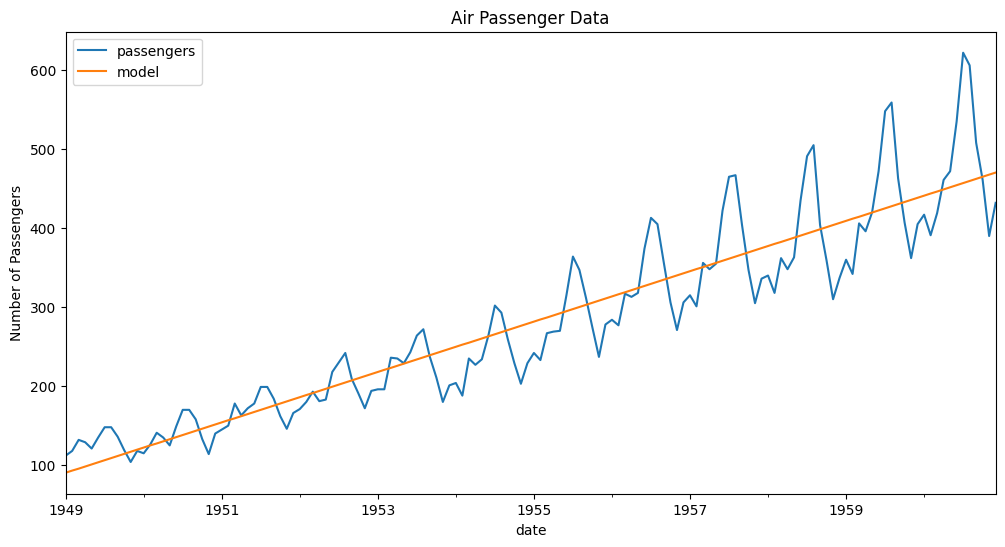

In [13]:
pd.DataFrame({'passengers':model_data2['passengers'],
              'model':model2.predict(X2)})\
         .plot(figsize=(12,6), title='Air Passenger Data', legend=True)\
         .set_ylabel('Number of Passengers')


Ok, looks reasonable.  But here comes the big problem, the seasonal changes introduce large residuals and therefore we have a difficult time to ascertain how good our model acutally is with respect to the trend,

In [14]:
# compute the R^2 score
dsutils.rs_score(model2, X2, y2, as_string=True)


'R^2 Score: 0.85 (0.81, 0.90)'

**Observation**: We obtained a much better trend model when actually modeling the trend curve rather than the original data!

# Time Series Modeling

Next we build a model on the actual time series data.  We will use a **gradient boosting regression** model.

In [15]:
# feature engineering
model_data3 = air.copy()
model_data3['days'] = list((model_data3.index - model_data3.index[0]).days)
model_data3

,passengers,days
date,,
1949-01-01,112,0
1949-02-01,118,31
1949-03-01,132,59
1949-04-01,129,90
1949-05-01,121,120
...,...,...
1960-08-01,606,4230
1960-09-01,508,4261
1960-10-01,461,4291


In [16]:
X = model_data3[['days']]
y = model_data3['passengers']


In [17]:

# fit a gradient boosting model
gbr_model = GradientBoostingRegressor().fit(X,y)


Text(0, 0.5, 'Number of Passengers')

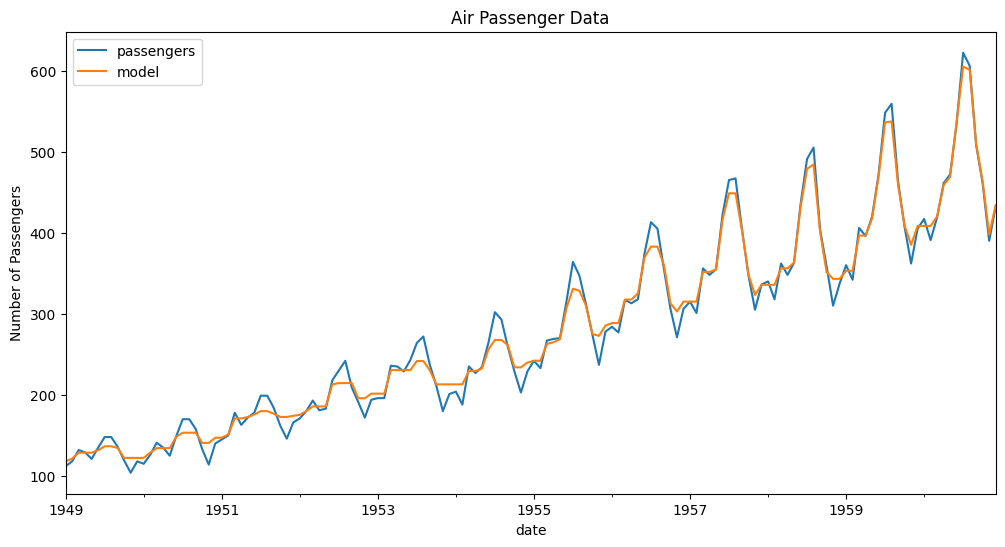

In [18]:
pd.DataFrame({'passengers':model_data3['passengers'],
              'model':gbr_model.predict(X)})\
         .plot(figsize=(12,6), title='Air Passenger Data', legend=True)\
         .set_ylabel('Number of Passengers')

In [19]:
mean_absolute_error(y,gbr_model.predict(X))

9.316944190672602

**Note**: We use mean absolute error here because the $R^2$ is almost meaningless here, it will always return something close to 1.

A feature of gradient boosting is that we can simply add estimators. Let's change from the default of 100 estimators to 500 estimators.

In [20]:

# fit the new gradient boosting model
gbr_model = GradientBoostingRegressor(n_estimators=500).fit(X,y)

Text(0, 0.5, 'Number of Passengers')

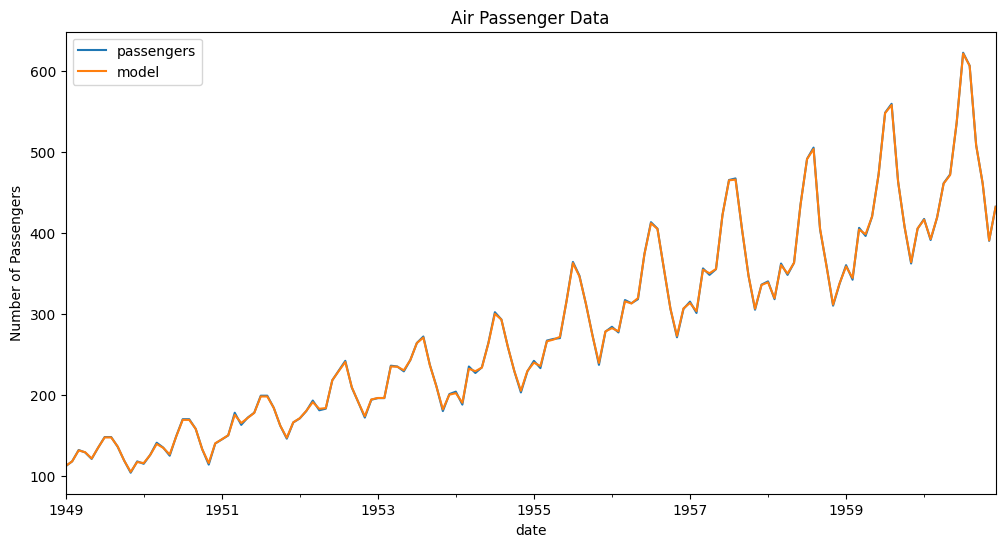

In [21]:

pd.DataFrame({'passengers':model_data3['passengers'],
              'model':gbr_model.predict(X)})\
         .plot(figsize=(12,6), title='Air Passenger Data', legend=True)\
         .set_ylabel('Number of Passengers')


In [22]:
mean_absolute_error(y,gbr_model.predict(X))


0.864202007435495

We could continue this, but this score is already pretty good, notice in the plot it covers the original curve almost completely.